# Masking Multivariate Normal CDF

In [1]:
#!git clone --recursive https://github.com/SebastienMarmin/torch-mvnorm

In [2]:
#import sys
#sys.path.append("torch-mvnorm/")

In [3]:
import scipy
import scipy.stats as st

In [4]:
import torch
import torch.distributions as td
from mvnorm import multivariate_normal_cdf

In [228]:
import torch
import torch.distributions as td
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from itertools import product
import numpy as np
from torch.distributions.utils import _standard_normal, broadcast_all
from entmax import sparsemax


class GaussianSparsemax(td.Distribution):
    
    arg_constraints = {
        'loc': constraints.real, 
        'scale': constraints.positive
    }    
    support = td.constraints.simplex
    has_rsample = True
    
    @classmethod
    def all_faces(K):
        """Generate a list of 2**K - 1 bit vectors indicating all possible faces of a K-dimensional simplex."""
        return list(product([0, 1], repeat=K))[1:]

    def __init__(self, loc, scale, validate_args=None):
        self.loc, self.scale = broadcast_all(loc, scale)
        batch_shape, event_shape = self.loc.shape[:-1], self.loc.shape[-1:]
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(GaussianSparsemax, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape + self.event_shape)
        new.scale = self.scale.expand(batch_shape + self.event_shape)
        super(GaussianSparsemax, new).__init__(batch_shape, self.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def rsample(self, sample_shape=torch.Size()):
        # sample_shape + batch_shape + (K,)
        z = td.Normal(loc=self.loc, scale=self.scale).rsample(sample_shape)
        return sparsemax(z, dim=-1)
    
    def IS(self, loc, cov, diag, sample_size):
        q = td.Normal(loc=loc, scale=diag)
        p = td.MultivariateNormal(loc, cov, validate_args=False)
        # [S, B, K]
        x = q.sample((sample_size,))
        x = torch.where(x > 0, -x, x)        
        # [S, B]
        log_prob = (p.log_prob(x) - 2.0*q.log_prob(x).sum(-1)).logsumexp(0) - np.log(sample_size)
        return log_prob        
    
    def log_prob(self, y, pivot_alg='first', tiny=1e-9, huge=1e9):
        K = y.shape[-1]
        # [B, K]
        loc = self.loc
        scale = self.scale
        var = scale ** 2
        
        # The face contains the set of coordinates greater than zero
        # [B, K]
        face = y > 0 

        # Chose a pivot coordinate (a non-zero coordinate)
        # [B]
        if pivot_alg == 'first':
            ind_pivot = torch.argmax((face > 0).float(), -1)
        elif pivot_alg == 'random':
            ind_pivot = td.Categorical(
                probs=face.float()/(face.float().sum(-1, keepdims=True))
            ).sample()
        # Select a batch of pivots 
        # [B, K]
        pivot_indicator = torch.nn.functional.one_hot(ind_pivot, K).bool()
        # All non-zero coordinates but the pivot
        # [B, K]
        others = torch.logical_xor(face, pivot_indicator)
        # The value of the pivot coordinate
        # [B]
        t = (y * pivot_indicator.float()).sum(-1)
        # Pivot mean and variance
        # [B]
        t_mean = torch.where(pivot_indicator, loc, torch.zeros_like(loc)).sum(-1)
        t_var = torch.where(pivot_indicator, var, torch.zeros_like(var)).sum(-1)

        # Difference with respect to the pivot
        # [B, K]
        y_diff = torch.where(others, y - t.unsqueeze(-1), torch.zeros_like(y))
        # [B, K]
        mean_diff = torch.where(
            others, 
            loc - t_mean.unsqueeze(-1),
            torch.zeros_like(loc)
        )
        
        # Joint log pdf for the non-zeros
        # [B, K, K]    
        diag = torch.diag_embed(torch.where(others, var, torch.ones_like(var)))
        offset = t_var.unsqueeze(-1).unsqueeze(-1)
        # We need a multivariate normal for the non-zero coordinates in `other`
        # but to batch mvns we will need to use K-by-K covariances
        # we can do so by embedding the lower-dimensional mvn in a higher dimensional mvn
        # with cov=I.
        # [B, K, K]
        cov_mask = others.unsqueeze(-1) * others.unsqueeze(-2)
        cov = torch.where(cov_mask, diag + offset, diag)
        # This computes log prob of y[other] under  the lower dimensional mvn
        # times log N(0|0,1) for the other dimensions
        # [B]
        log_prob = td.MultivariateNormal(mean_diff, cov).log_prob(y_diff)
        # so we discount the contribution from the masked coordinates
        # [B, K]
        log_prob0 = td.Normal(torch.zeros_like(mean_diff), torch.ones_like(mean_diff)).log_prob(torch.zeros_like(y_diff)) 
        # [B]
        log_prob = log_prob - torch.where(others, torch.zeros_like(log_prob0), log_prob0).sum(-1)

        # Joint log prob for the zeros (needs the cdf)
        # [B]
        constant_term = 1. / torch.where(face, 1./var, torch.zeros_like(var)).sum(-1)
        # Again, we aim to reason with lower-dimensional mvns via 
        # the td.MultivariateNormal interface. For that, I will mask the coordinates in face.
        # The non-zeros get a tiny variance
        # [B, K, K]
        diag_corrected = torch.diag_embed(torch.where(face, torch.zeros_like(var) + tiny, var)) 
        # [B, 1, 1]
        offset_corrected = constant_term.unsqueeze(-1).unsqueeze(-1)
        # These are the zeros only.
        # [B, K, K]
        cov_corrected_mask = torch.logical_not(face).unsqueeze(-1) * torch.logical_not(face.unsqueeze(-2))    
        cov_corrected = torch.where(cov_corrected_mask, diag_corrected + offset_corrected, diag_corrected)    

        # The non-zeros get a large negative mean.
        # [B]
        mean_constant_term = constant_term * torch.where(face, (y - loc)/var, torch.zeros_like(y)).sum(-1)
        # [B, K]
        #  see that for non-zeros I move the location to something extremely negative
        #  in combination with tiny variace this makes the density of 0 evaluate to 0
        #  and the cdf of 0 evaluate to 1, for those coordinates
        mean_corrected = torch.where(face, torch.zeros_like(y) - huge, loc + mean_constant_term.unsqueeze(-1))

        # [B]
        cdf = multivariate_normal_cdf(
            torch.zeros_like(y),
            mean_corrected, cov_corrected
        )        
        log_cdf = cdf.log()
        #try:
        print(cdf)
        print(self.IS(mean_corrected, cov_corrected, torch.where(face, torch.zeros_like(var) + tiny, var), 100000))
        #except:
        #    print("error")
        # log F(0; u, S)
        # log \int_{x<0} MVN(x|u,S) dx
        # log \int_{x<0} q(x) MVN(x|u,S)/q(x) dx
        # log E[ MVN(x|u,S) / q(x)]
        # 
        #print('log_cdf', log_cdf.device)
        #if log_cdf.device != log_prob.device:
        #    print("changing device")
        #    log_cdf = torch.tensor(log_cdf, device=log_prob.device)

        # [B]
        log_det = face.float().sum(-1).log()

        # [B]
        return log_prob + log_cdf + log_det
    
    def log_prob_IS(self, y, imp_samples=1000):

        assert y.shape[:-1] == self.batch_shape, "For now I need the same batch_shape"
        
        batch_shape = y.shape[:-1]
        K = self.loc.shape[-1]

        # [B]
        dtau = td.Normal(
            loc=torch.zeros(batch_shape, device=self.loc.device), 
            scale=torch.ones(batch_shape, device=self.scale.device)
        )
        # [B, K]
        dnu = td.LogNormal(
            loc=torch.zeros(batch_shape + (K,), device=self.loc.device), 
            scale=torch.ones(batch_shape + (K,), device=self.scale.device) * 3
        )
        
        
        # [B]
        n = (y > 0).float().sum(-1)
        
        # [S, B, K]
        y = y.expand((imp_samples,) + batch_shape + (K,))
        
        # [S, B, K]
        antisupp = y == 0
        # [S, B]
        n_antisupp = antisupp.float().sum(-1)
        # [S, B]
        taus = dtau.sample(sample_shape=(imp_samples,))
        # [S, B, K]
        nus = dnu.sample(sample_shape=(imp_samples,))

        
        # [S, B, K] 
        X = y + taus.unsqueeze(-1)
        X = X - torch.where(antisupp, nus, torch.zeros_like(nus))

        # this just asserts we are sampling over the correct set
        # print("Error: ", torch.sum((sparsemax(X, 1) - y) ** 2))

        # probability of each of these Xs
        # [S, B]
        logp_X = td.Normal(loc=self.loc, scale=self.scale).log_prob(X).sum(-1)

        # probability of our importance distribution (iid over tau and nu)
        # [S, B]
        logq_X = dtau.log_prob(taus) 
        # [S, B]
        logq_X += torch.where(antisupp, dnu.log_prob(nus), torch.zeros_like(nus)).sum(-1)

        # \int_s p(x) dx = E_p [1_S] = E_q[1_S * p/q]
        # 1_S is 1 by construction

        ## this multiplication by n here gives the expected result
        ##  - in the 2d case
        ##  - in the 3d case when looking at dimension 1- and 2- faces.
        ## WHERE DOES IT COME FROM? I discovered it just randomly.
        ## Can we check if this gives correct values on the interior on the 3-simplex?
        # [B]
        log_prob = (logp_X - logq_X).logsumexp(0) - np.log(imp_samples)
        log_prob += n.log()
        
        return log_prob


@td.register_kl(GaussianSparsemax, GaussianSparsemax)
def _kl_gaussiansparsemax_gaussiansparsemax(p, q):
    x = p.rsample()
    return p.log_prob(x) - q.log_prob(x)

In [21]:
def density(y, base_dists, ind_pivot=0):
    """
    Evaluate the density of y. Can optionally pick a pivot.
    y_nz contains only the non-zeros, corresponding to the non-masked
    entries of the face.
    """
    face = y > 0
    y_nz = y[np.nonzero(face)[0]]
    from scipy.stats import multivariate_normal

    nz = np.nonzero(face)[0]
    zeros = np.nonzero(1-np.array(face))[0]
    pivot = nz[ind_pivot]
    nz_minus_pivot = np.array(list(set(nz) - {pivot}))
    y = np.zeros(len(face))
    y[nz] = y_nz

    # Compute density contribution by the nonzeros - requires pdf.
    y_diff = np.array([y[s] - y[pivot] for s in nz_minus_pivot])
    mean_diff = np.array([base_dists[s].mean() - base_dists[pivot].mean() for s in nz_minus_pivot])
    if len(nz_minus_pivot):
        cov = np.diag(np.array([base_dists[s].var() for s in nz_minus_pivot])) + base_dists[pivot].var()
        val = multivariate_normal(mean=mean_diff, cov=cov).pdf(y_diff)
    else:
        val = 1
    
    # Compute density contribution by the zeros - requires cdf.
    if len(zeros):
        constant_term = 1 / sum([1/base_dists[s].var() for s in nz])
        cov_corrected = np.diag(np.array([base_dists[r].var() for r in zeros])) + constant_term
        mean_constant_term = (constant_term *
                              sum(np.array([(y[s] - base_dists[s].mean())/base_dists[s].var() for s in nz])))
        mean_corrected = np.array([base_dists[r].mean() + mean_constant_term for r in zeros])
        cdf = multivariate_normal(mean=mean_corrected, cov=cov_corrected).cdf(np.zeros(len(zeros)))
        val *= cdf    
    val *= sum(face)  # This is the determinant of the transformation Y -> U = g(Y) for the nonzeros.
    return val

In [229]:
p = GaussianSparsemax(
    loc=td.Normal(0., 1.).sample((8, 5,)).to(torch.device('cuda:1')), 
    scale=td.Gamma(1., 1.).sample((8, 5,)).to(torch.device('cuda:1'))/4
)
x = p.sample()
x

tensor([[0.7339, 0.0000, 0.0000, 0.0000, 0.2661],
        [0.8412, 0.0000, 0.0000, 0.1588, 0.0000],
        [0.0000, 0.0000, 0.3623, 0.6377, 0.0000],
        [0.0000, 0.4134, 0.4350, 0.1516, 0.0000],
        [0.7539, 0.0000, 0.2461, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5136, 0.0418, 0.4445],
        [0.0000, 0.0000, 0.3882, 0.6118, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:1')

In [230]:
p.log_prob(x)

tensor([0.8842, 1.0000, 0.9960, 0.9208, 0.0353, 1.0000, 0.9889, 0.6450],
       device='cuda:1', dtype=torch.float64)
tensor([-55.3063, -57.9804, -65.7051, -89.7737,  82.6449, -90.6306, -63.9083,
        -29.0333], device='cuda:1')


tensor([ 0.3013,  2.4685,  1.5994, -0.2397, -2.7674, -1.1220, -0.1170, -0.4385],
       device='cuda:1', dtype=torch.float64)

In [206]:
rows = []
for n in range(x.shape[0]):
    rows.append([' '.join(f"{v:.2f}" for v in x.cpu().numpy()[n])])
    rows[-1].append(np.log(density(x[n].cpu().numpy(), [st.norm(loc=u.cpu().numpy(), scale=s.cpu().numpy()) for u, s in zip(p.loc[n], p.scale[n])])))

In [207]:
for i, v in enumerate(p.log_prob(x).cpu().numpy()):
    rows[i].append(v)

tensor([1.0000, 0.7109, 0.7755, 1.0000, 0.2994, 1.0000, 1.0000, 0.9406],
       device='cuda:1', dtype=torch.float64)
torch.Size([8, 5]) torch.Size([8, 5, 5]) torch.Size([8, 5])
error


In [208]:
for i, v in enumerate(p.log_prob_IS(x, imp_samples=1000000).cpu().numpy()):
    rows[i].append(v)

In [209]:
from tabulate import tabulate
print(tabulate(rows, headers=['x', 'scipy cdf', 'torch cdf', 'IS']))

x                           scipy cdf     torch cdf         IS
------------------------  -----------  ------------  ---------
0.00 1.00 0.00 0.00 0.00  -3.3606e-08  -5.10443e-07  -1.83669
0.70 0.00 0.00 0.30 0.00  -0.317364    -0.317364     -2.01974
0.88 0.00 0.06 0.00 0.06   1.9305       1.9305        1.95394
0.74 0.00 0.00 0.00 0.26   1.14177      1.14177       1.36368
0.00 0.00 1.00 0.00 0.00  -1.20585     -1.20586      -1.19314
0.00 0.42 0.39 0.19 0.00   2.90539      2.90539       2.96719
0.00 0.00 0.20 0.80 0.00  -1.1042      -1.1042       -2.25844
0.00 0.00 0.71 0.29 0.00   0.355046     0.355047      0.343735


In [48]:
batch_size = 5
for K in [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 10, 10]:
    print(f"batch_size={batch_size} K={K}")
    all_y = []
    all_u = []
    all_s = []
    all_r1 = []
    for n in range(batch_size):
        u = torch.tensor(np.random.normal(0., 1., size=K), requires_grad=True, device=torch.device('cuda:0'))
        s = torch.tensor(np.random.normal(1., 1., size=K), requires_grad=True, device=torch.device('cuda:0'))
        s = torch.nn.functional.softplus(s)
        all_u.append(u)
        all_s.append(s)
        y = GaussianSparsemax(u, s).sample()
        all_y.append(y)
        all_r1.append(np.log(density(y.detach().cpu().numpy(), [st.norm(loc=u.detach().cpu().numpy()[k], scale=s.detach().cpu().numpy()[k]) for k in range(K)])))    

    # make a batch
    Y = torch.stack(all_y)
    U = torch.stack(all_u)
    S = torch.stack(all_s)
    all_r2 = GaussianSparsemax(U, S).log_prob(Y, pivot_alg='first')
    
    all_r3 = GaussianSparsemax(U, S).log_prob(Y, pivot_alg='random')

    print(" pass pivot='first':", torch.isclose(torch.tensor(all_r1), all_r2.cpu(), atol=1e-3).all().item())
    print(" pass pivot='random':", torch.isclose(torch.tensor(all_r1), all_r3.cpu(), atol=1e-3).all().item())
    
    def get_loss(values, locs, scales, reduce=True):
        loss = - GaussianSparsemax(locs, scales).log_prob(values)
        return loss.mean() if reduce else loss
    
    grad_check = torch.autograd.gradcheck(
        get_loss, 
        [Y, U, S], 
        eps=1e-02, 
        atol=0.1, 
        rtol=0.001, 
        raise_exception=True, 
        check_sparse_nnz=False, 
        nondet_tol=0.1, 
        check_undefined_grad=True, 
        check_grad_dtypes=False, 
        check_batched_grad=False
    )
    print(" pass gradient check:", grad_check)

batch_size=5 K=1
 pass pivot='first': True
 pass pivot='random': True
 pass gradient check: True
batch_size=5 K=1
 pass pivot='first': True
 pass pivot='random': True
 pass gradient check: True
batch_size=5 K=2
 pass pivot='first': True
 pass pivot='random': True
 pass gradient check: True
batch_size=5 K=2
 pass pivot='first': True
 pass pivot='random': True
 pass gradient check: True
batch_size=5 K=3
 pass pivot='first': True
 pass pivot='random': True
 pass gradient check: True
batch_size=5 K=3
 pass pivot='first': True
 pass pivot='random': True


KeyboardInterrupt: 

In [8]:
p = GaussianSparsemax(td.Normal(0., 1.).sample((10,)), td.Gamma(1., 1.).sample((10,)))
q = GaussianSparsemax(td.Normal(0., 1.).sample((10,)), td.Gamma(1., 1.).sample((10,)))

In [9]:
td.kl_divergence(p, p), td.kl_divergence(p.expand((100,)), p.expand((100,))).mean(0)

(tensor(-2.2173e-05), tensor(-2.0148e-06, dtype=torch.float64))

In [10]:
td.kl_divergence(p, q)

tensor(0.2190)

In [11]:
td.kl_divergence(p.expand((1000,)), q.expand((1000,))).mean(0)

tensor(inf, dtype=torch.float64)

In [12]:
x = p.sample((1000,))

In [13]:
(p.log_prob(x) - q.log_prob(x)).mean(0)

tensor(inf, dtype=torch.float64)

In [14]:
import probabll.distributions as pd

class GaussianSparsemaxPrior(td.Distribution):
    
    def __init__(self, pF, alpha_net, validate_args=False):
        self.pF = pF
        self.alpha_net = alpha_net
        batch_shape, event_shape = pF.batch_shape, pF.event_shape        
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(GaussianSparsemaxPrior, _instance)
        new.pF = self.pF.expand(batch_shape)
        new.alpha_net = self.alpha_net
        super(GaussianSparsemaxPrior, new).__init__(batch_shape, self.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new        
        
    def sample(self, sample_shape=torch.Size()):
        f = self.pF.sample(sample_shape)
        Y = pd.MaskedDirichlet(f.bool(), self.alpha_net(f)) 
        return Y.sample()
        
    def log_prob(self, value):        
        f = (value > 0).float()       
        Y = pd.MaskedDirichlet(f.bool(), self.alpha_net(f)) 
        return self.pF.log_prob(f) + Y.log_prob(value)        
    
@td.register_kl(GaussianSparsemax, GaussianSparsemaxPrior)
def _kl_gaussiansparsemax_gaussiansparsemaxprior(p, q):
    x = p.rsample()
    return p.log_prob(x) - q.log_prob(x)

In [15]:
prior = GaussianSparsemaxPrior(
    #pd.MaxEntropyFaces(pd.MaxEntropyFaces.pmf_n(4, 1)),
    pd.NonEmptyBitVector(torch.zeros(4)),
    torch.ones_like
)

In [16]:
posterior = GaussianSparsemax(td.Normal(0., 1.).sample((4,)), td.Gamma(1., 1.).sample((4,)))

In [17]:
td.kl_divergence(posterior, prior)

tensor(2.3057)

In [18]:
prior.expand((10,)).sample()

tensor([[0.0000, 0.4524, 0.0000, 0.5476],
        [0.0000, 0.0000, 0.8698, 0.1302],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.2357, 0.7163, 0.0480, 0.0000],
        [0.0322, 0.2654, 0.6303, 0.0722],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0304, 0.2614, 0.7082, 0.0000],
        [0.0581, 0.0089, 0.4966, 0.4363],
        [0.0000, 0.2969, 0.2348, 0.4683],
        [0.0000, 0.0000, 0.0000, 1.0000]])

In [19]:
td.kl_divergence(posterior.expand((10,)), prior.expand((10,)))

tensor([1.6913, 2.2989, 1.2426, 1.0014, 2.2007, 0.4468, 1.4961, 0.4468, 2.2316,
        1.3618], dtype=torch.float64)

In [168]:
import probabll.distributions as pd

Init signature: td.transforms.AbsTransform(cache_size=0)
Docstring:      Transform via the mapping :math:`y = |x|`.
File:           ~/envs/mixedrv/lib/python3.7/site-packages/torch/distributions/transforms.py
Type:           type
Subclasses:     


In [172]:
t = td.transforms.AbsTransform()
#

In [175]:
t(torch.ones(3))

tensor([1., 1., 1.])

In [178]:
Np = td.TransformedDistribution(
    td.Normal(torch.zeros(1), torch.ones(1)),
    td.transforms.AbsTransform()
)

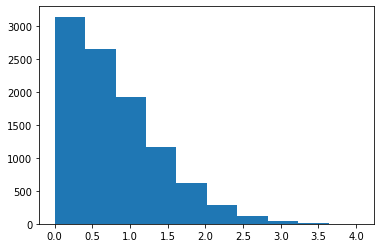

In [183]:
import matplotlib.pyplot as plt

_ = plt.hist(Np.sample((10000,)).cpu().numpy())

In [ ]:
Np.log_prob()